In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-08-26 13:08:37.357037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 13:08:37.395339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 13:08:37.396030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 13:08:38.108005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [2]:
def get_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
    """
    Adds a label representing the first main ec class (1-7) based on the ec number
    :param path_to_esm2: Absolute path to esm2 file
    :param path_to_enzyme_splitX_csv: Absolute path to splitX csv, which is needed for labeling
    :return: A dataframe containing the corresponding labels
    """
    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        headers = []
        embeddings = []

        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)
    
    print(len(embeddings))
    print(len(enzyme_csv)) 
    
    labels = {} # dict with → header(id): label (1-7)


    for header in headers:
        number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
        ec = int(number.iat[0][0])-1 # since we always start counting from 0
        labels[header] = ec
    
    header_label_tuples = [(header, labels[header]) for header in headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(headers, embeddings):
        label = next((label for h, label in header_label_tuples if h == header), None)
        if label is not None:
            embeddings_with_labels.append((header, label, emb))
    
    return embeddings_with_labels


### Creating X and y

In [3]:
enzyme_csv = os.getenv("CSV70_ENZYMES")
esm2_enzymes = os.getenv("ESM2_ENZYMES_SPLIT_70")

labels = get_ec_labels(path_to_enzyme_esm2=esm2_enzymes, path_to_enzyme_splitX_csv=enzyme_csv)

X = []
y = []
for entry in labels:
    y.append(entry[1]) # append label (1-7)
    X.append(entry[2]) # append embedding

73553
73553


73553
73553


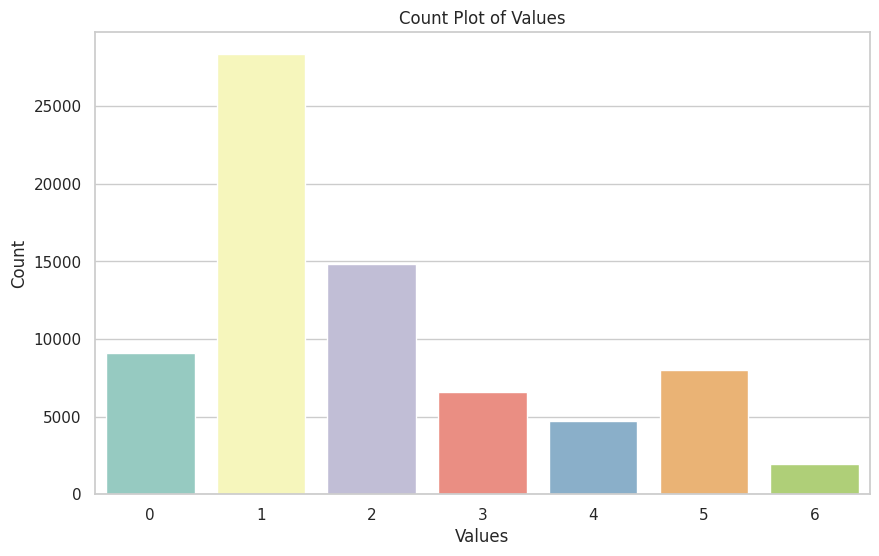

In [4]:

print(len(X))
print(len(y))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

In [5]:
# Create a DataFrame
df = pd.DataFrame({"feature1":X, "label":y})


# Convert the lists in 'feature1' into separate columns using pd.DataFrame constructor
feature_columns = pd.DataFrame(df["feature1"].tolist(), columns=[f"feature_{i+1}" for i in range(2560)])

# Concatenate the feature columns with the original DataFrame
df = pd.concat([df.drop("feature1", axis=1), feature_columns], axis=1)

# Display the resulting DataFrame
print(df.head())


   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      2  -0.062921  -0.092207  -0.001200   0.014007   0.005149   0.053362   
1      0  -0.053399   0.026311   0.068040  -0.047504  -0.056120   0.021154   
2      2  -0.015143   0.035552  -0.022313   0.002838  -0.011048  -0.017585   
3      2  -0.061284   0.034236  -0.034158  -0.106900  -0.030302  -0.071545   
4      0   0.059097  -0.034141   0.061427   0.006349  -0.058036  -0.020592   

   feature_7  feature_8  feature_9  ...  feature_2551  feature_2552  \
0  -0.016877   0.105275  -0.002420  ...      0.026946     -0.044988   
1  -0.073030   0.139663   0.022752  ...      0.032434     -0.056128   
2  -0.095678   0.095675   0.048721  ...     -0.021529     -0.027920   
3  -0.067266   0.009058   0.049455  ...      0.084735     -0.049660   
4  -0.064093   0.100111   0.019740  ...      0.089701     -0.076780   

   feature_2553  feature_2554  feature_2555  feature_2556  feature_2557  \
0      0.028635      0.025759

In [11]:

X = df.drop('label', axis=1).values
y = df['label'].values



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)


In [47]:
len(X_train[0])

2560

In [65]:
earl_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=50)

In [66]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification
# model.add(
#     tf.keras.layers.Dense(units=2560, activation="relu", input_shape=(2560,))
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=15, activation="relu")
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=7, activation='softmax') # da classification
# )

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [58]:
model.fit(x=X_train, y=y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.7462 - val_loss: 3.3554
Epoch 2/100
1609/1609 [==============================] - 17s 11ms/step - loss: 0.3430 - val_loss: 3.3158
Epoch 3/100
1609/1609 [==============================] - 17s 11ms/step - loss: 0.2690 - val_loss: 3.3479
Epoch 4/100
1609/1609 [==============================] - 17s 10ms/step - loss: 0.2352 - val_loss: 4.0334
Epoch 5/100
1609/1609 [==============================] - 17s 10ms/step - loss: 0.2002 - val_loss: 4.8536
Epoch 6/100
1609/1609 [==============================] - 17s 10ms/step - loss: 0.1883 - val_loss: 5.8342
Epoch 7/100
1609/1609 [==============================] - 17s 10ms/step - loss: 0.1719 - val_loss: 6.2078
Epoch 8/100
1609/1609 [==============================] - 17s 11ms/step - loss: 0.1664 - val_loss: 3.0654
Epoch 9/100
1609/1609 [==============================] - 17s 10ms/step - loss: 0.1493 - val_loss: 2.3943
Epoch 10/100
1609/1609 [==============================]

<Axes: >

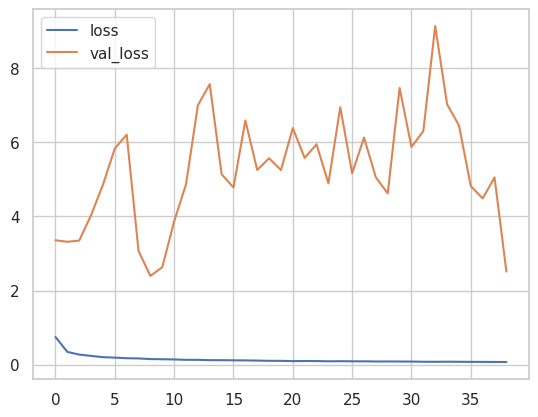

In [59]:
model_loss = pd.DataFrame(model.history.history)

model_loss.plot() # early stopping where plot diverges


In [60]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

690/690 [==============================] - 2s 2ms/step


In [61]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print(counter)
print(len(y_test))

19421
22066


In [76]:
report = classification_report(y_test, predictions)

class_0_metrics = report.split('\n')[3].split()[1:]
class_1_metrics = report.split('\n')[4].split()[1:]
class_2_metrics = report.split('\n')[5].split()[1:]
class_3_metrics = report.split('\n')[6].split()[1:]
class_4_metrics = report.split('\n')[7].split()[1:]
class_5_metrics = report.split('\n')[8].split()[1:]
class_6_metrics = report.split('\n')[9].split()[1:]

metrics = [class_0_metrics,
           class_1_metrics,
           class_2_metrics,
           class_3_metrics,
           class_4_metrics,
           class_5_metrics,
           class_6_metrics
           ]
i = 1
for class_m in metrics:
    accuracy = float(class_0_metrics[0])
    precision = float(class_0_metrics[1])
    recall = float(class_0_metrics[2])
    f1_score = float(class_0_metrics[3])
    print(f"Accuracy for class {i}: {accuracy}")
    print(f"Precision for class {i}: {precision}")
    print(f"Recall for class {i}: {recall}")
    print(f"F1-score for class {i}: {f1_score}")
    i+=1
print(report)

Accuracy for class 1: 0.83
Precision for class 1: 0.99
Recall for class 1: 0.9
F1-score for class 1: 8548.0
Accuracy for class 2: 0.83
Precision for class 2: 0.99
Recall for class 2: 0.9
F1-score for class 2: 8548.0
Accuracy for class 3: 0.83
Precision for class 3: 0.99
Recall for class 3: 0.9
F1-score for class 3: 8548.0
Accuracy for class 4: 0.83
Precision for class 4: 0.99
Recall for class 4: 0.9
F1-score for class 4: 8548.0
Accuracy for class 5: 0.83
Precision for class 5: 0.99
Recall for class 5: 0.9
F1-score for class 5: 8548.0
Accuracy for class 6: 0.83
Precision for class 6: 0.99
Recall for class 6: 0.9
F1-score for class 6: 8548.0
Accuracy for class 7: 0.83
Precision for class 7: 0.99
Recall for class 7: 0.9
F1-score for class 7: 8548.0
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2689
           1       0.83      0.99      0.90      8548
           2       0.95      0.86      0.90      4467
           3       0.93    

In [63]:
print(confusion_matrix(y_test, predictions))


[[2222  288   46   25    0   82   26]
 [   4 8467   26    5    1   45    0]
 [  17  548 3838    9    2   53    0]
 [  25  299   70 1418    0  149    0]
 [  29  618   48   63  512  120    0]
 [   0   17    7    0    0 2433    0]
 [   3   19    0    0    0    1  531]]


In [64]:
model.save("initial_ann_v2_70_acc88")

INFO:tensorflow:Assets written to: initial_ann_v2_70_acc88/assets


INFO:tensorflow:Assets written to: initial_ann_v2_70_acc88/assets
